**Подготовка colab notebook**

1.Скопируйте этот colab (go to File-->Save copy in Drive)

2.В открывшемся новом colab:

переименуйте название следующим образом "Тестовое задание ShiftLab 2022 Computer Vision [ваше имя фамилия].ipynb" 

например,
"Тестовое задание ShiftLab 2022 Computer Vision Иван Иванов.ipynb"


#Необходимо создать и обучить multi-output классификатор изображений







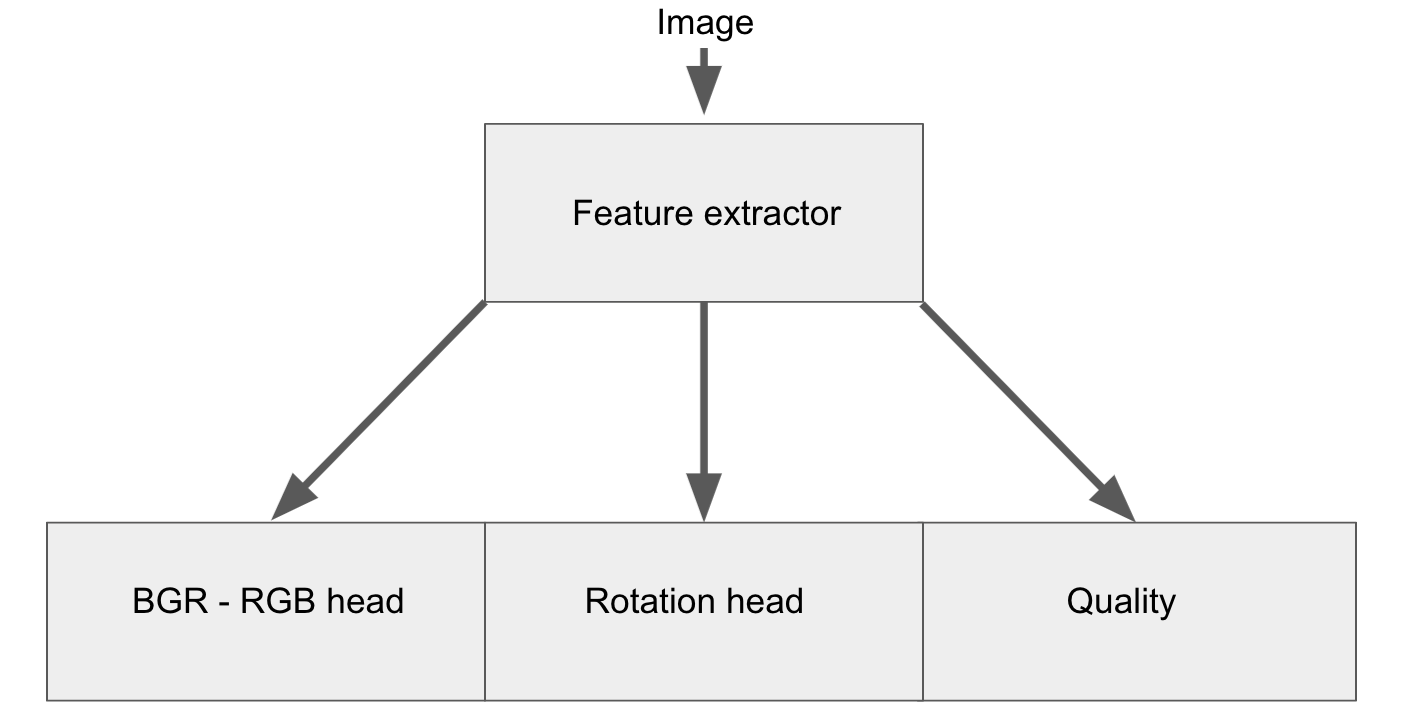

# На вход в классификатор подается изображение, на выходе должны быть вероятности для следующих классов:
### Выход качество: 

классы: 

1. Blur - фото смазано 

2. Torch -  фото засвечено

3. Sharp - фото хорошего качества, резкое

### Выход поворот:

классы: 

1. Поворот отсутствует 0 градусов

2. Поворот по часовой стрелке на 90 градусов

3. Поворот против часовой стрелке на 90 градусов

4. Перевернутое фото 180 градусов


### Выход  RGB-BGR:

классы:

1. RGB

2. BGR




 

## Особенности задания

1. Можно использовать любые открытые датасеты. Ниже найдете пример датасета.
2. Решение должно быть именно Вашим, уникальным и не повторяться с другими участниками.
4. Можно использовать любой удобный фреймворк (Pytorch, FastAI, Keras, Tensorflow)
5.Назовите папку для датасета DATASET_DIR в следующем формате : первая буква вашего имени,ваша фамилия, название датасета например : v_ivanov_images_dataset. Так мы сможем быстрее проверить решение


# Как начать


## Загрузка датасета с kaggle

In [1]:
# set up kaggle json in colab and download the dataset
# make sure you downloaded kaggle.json locally from kaggle profile https://www.kaggle.com/YOURDISPLAYNAME/account

! pip install -q kaggle

import os
from google.colab import files

if not os.path.exists("/root/.kaggle/kaggle.json"):
  files.upload()
  ! mkdir -p ~/.kaggle
  ! mv kaggle.json ~/.kaggle/ 
  ! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
# example downloading dataset
!kaggle datasets download -d kwentar/blur-dataset
!unzip -qq blur-dataset.zip -d ./

 99% 1.48G/1.49G [00:15<00:00, 128MB/s]
100% 1.49G/1.49G [00:15<00:00, 102MB/s]


Dataset was cloned after loading, remove extra dirs. And rename dir with dataset will be used.

In [3]:
!mv /content/blur_dataset_scaled /content/a_arestov_images_dataset
!mv /content/a_arestov_images_dataset/defocused_blurred /content/a_arestov_images_dataset/blur 
!rm -rf /content/defocused_blurred
!rm -rf /content/motion_blurred
!rm -rf /content/sharp

## Labels dict

In [ ]:
dataset_dict = {
    'quality': {0: 'blur',   1: 'torch',   2:'sharp'},
    'angle':   {0:  '0',     1: '90r',     2: '90l',   3: '180'}, 
    'format':  {0: 'rgb',    1: 'bgr'}
    }
'''
dataset_dict['quality_alias'] = dict((g, i) for i, g in dataset_dict['quality'].items())
dataset_dict['angle_alias'] = dict((r, i) for i, r in dataset_dict['angle'].items())
dataset_dict['format_alias'] = dict((f, i) for i, f in dataset_dict['format'].items())
'''

In [ ]:
# remove extra dirs
# !rm -rf /content/a_arestov_images_dataset/blur_to_gbr

# copy dir
# !cp -R /content/a_arestov_images_dataset/blur /content/a_arestov_images_dataset/blur_to_gbr

# Prepare data

https://imgaug.readthedocs.io/en/latest/source/overview/imgcorruptlike.html - fog & freeze & brightness

https://imgaug.readthedocs.io/en/latest/source/overview/weather.html

**Summary**: i didn't manage to find any mention of sun glares or whatever applied in python, so i decided to blend sharp pictures and motion blur ones. Photos into dataset are triplet, so we can find pair 'sharp-mot_blur' for every picture (due to there are strictly 350 per triplet) with just sorting content of irs by name (fortunately, images have similar names).

Example is below. 

In [4]:
import matplotlib.pyplot as plt
from PIL import Image
from IPython.lib.display import join
import shutil 
from tqdm import tqdm

## Resizing

In [5]:
path = '/content/a_arestov_images_dataset/'

blur_path = path + 'blur/'
mot_blur_path = path + 'motion_blurred/'
sharp_path = path + 'sharp/'

def resize_dir(dir = blur_path):
    for i, file_name in enumerate(tqdm(os.listdir(dir))):
        img = Image.open(dir+file_name).resize((224,224))
        os.remove(dir+file_name)
        img.save(dir+file_name)

In [6]:
resize_dir(dir = blur_path)
resize_dir(dir = mot_blur_path)
resize_dir(dir = sharp_path)

100%|██████████| 350/350 [00:37<00:00,  9.23it/s]


## Example of image blending

In [11]:
n = 124
print(sorted(os.listdir('/content/a_arestov_images_dataset/sharp'))[n])
print(sorted(os.listdir('/content/a_arestov_images_dataset/motion_blurred'))[n])

211_SAMSUNG-GALAXY-7-NEO_S.jpg
211_SAMSUNG-GALAXY-7-NEO_M.jpg


In [12]:
n = 0
img1 = Image.open(mot_blur_path + \
                  str( sorted(os.listdir(mot_blur_path))[n] )).resize((500,300))
img2 = Image.open(sharp_path + \
                  str( sorted(os.listdir(sharp_path))[n] )).resize((500,300)) # normal sharp
img3 = Image.blend(img1, img2, 1.7)

0_IPHONE-SE_M.JPG
0_IPHONE-SE_S.JPG


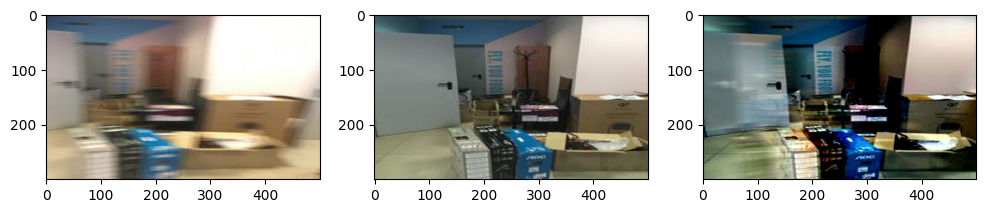

In [13]:
print(sorted(os.listdir(mot_blur_path))[n])
print(sorted(os.listdir(sharp_path))[n])
fig, ax = plt.subplots(1,3, figsize=(12, 9))
ax[0].imshow(img1)
ax[1].imshow(img2)
ax[2].imshow(img3) # product

## Blending (create 'torched' images)

Expand the sample with 'torch' images:

In [7]:
!mkdir /content/a_arestov_images_dataset/torch

In [8]:
source_mot_blur = path + 'motion_blurred/'
source_sharp = path + 'sharp/'
source_torch = path + 'torch/'

for i, file_name in enumerate(tqdm(os.listdir(source_mot_blur))):
    name, extension = os.path.splitext(file_name)
    blure_img = Image.open(source_mot_blur + \
                  str( sorted(os.listdir(mot_blur_path))[i] ))
    sharp_img = Image.open(source_sharp + \
                  str( sorted(os.listdir(sharp_path))[i] )).resize((224,224)) # normal sharp
    torch_img = Image.blend(blure_img, sharp_img, 1.7) 
    
    # save and label images accoring 'torch' '0 deg' 'BGR'
    torch_img.save(f'{source_torch}/' + f'1_0_1_{i}'+f'{extension}') # torch 0deg bgr

100%|██████████| 350/350 [00:02<00:00, 149.03it/s]


In [9]:
!rm -rf /content/a_arestov_images_dataset/motion_blurred
len(os.listdir(source_torch))

350

In [ ]:
# for splitting 'defocused_blurred' and 'motion_blurred' (ну мало ли)
'''
from IPython.lib.display import join
import shutil 
from tqdm import tqdm

path = '/content/a_arestov_images_dataset/'
blur_dir = 'blur'
os.makedirs(os.path.join(path+blur_dir), exist_ok=True)

source_dir = os.path.join(path, 'defocused_blurred')
for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
    dest_dir = os.path.join(path+blur_dir) 
    shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

source_dir = os.path.join(path, 'motion_blurred')
for j, file_name in enumerate(tqdm(os.listdir(source_dir))):
    dest_dir = os.path.join(path+blur_dir) 
    shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))
'''

## А вот лэйбеллинг но покороче

In [10]:
def put_img_label(source_dir = os.path.join(path, 'blur'), label = '0_0_1_'):
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        name, extension = os.path.splitext(file_name)
        os.rename(source_dir+'/'+file_name, f'{source_dir}/'+ f'{label}{i}'+f'{extension}') 

put_img_label(source_dir = os.path.join(path, 'blur'), label = '0_0_1_')  # blur  0deg bgr
put_img_label(source_dir = os.path.join(path, 'sharp'), label = '2_0_1_') # sharp 0deg bgr

100%|██████████| 350/350 [00:00<00:00, 34792.65it/s]


In [ ]:
('1_0_1_') # torch 0deg bgr     ('1_1_1_') # torch 90r bgr      ('1_2_1_') # torch 90l bgr     ('1_3_1_') # torch 180 bgr     
('0_0_1_') # blur  0deg bgr     ('0_1_1_') # blur  90r bgr      ('0_2_1_') # blur  90l bgr     ('0_3_1_') # blur  180 bgr
('2_0_1_') # sharp 0deg bgr     ('2_1_1_') # sharp 90r bgr      ('0_2_1_') # blur  90l bgr     ('0_3_1_') # blur  180 bgr

('1_0_0_') # torch 0deg rgb     ('1_1_0_') # torch 90r rgb      ('1_2_0_') # torch 90l rgb     ('1_3_0_') # torch 180 rgb          
('0_0_0_') # blur  0deg rgb     ('0_1_0_') # blur  90r rgb      ('0_2_0_') # blur  90l rgb     ('0_3_0_') # blur  180 rgb    
('2_0_0_') # sharp 0deg rgb     ('2_1_0_') # sharp 90r rgb      ('2_2_0_') # blur  90l rgb     ('2_3_0_') # blur  180 rgb       

In [11]:
def rot_aug(img, i, extension, source_dir, qual_label, encode_label = 1):
    r90r = img.rotate(-90)
    r90r.save(f'{source_dir}/' + f'{qual_label}_1_{encode_label}_{i}'+f'{extension}')
    r90l = img.rotate(90)
    r90l.save(f'{source_dir}/' + f'{qual_label}_2_{encode_label}_{i}'+f'{extension}')
    r180 = img.rotate(180)
    r180.save(f'{source_dir}/' + f'{qual_label}_3_{encode_label}_{i}'+f'{extension}')

In [12]:
def augmentation(source_dir = os.path.join(path, 'blur'), qual_label = '0'):
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        name, extension = os.path.splitext(file_name)
        img = Image.open(source_dir+'/'+file_name)
        b, g, r = img.split()
        image_rgb = Image.merge("RGB", (r, g, b))
        image_rgb.save(f'{source_dir}/' + f'{qual_label}_0_0_{i}'+f'{extension}')

        rot_aug(img, i, extension, source_dir, qual_label, encode_label = 1) # for BGR
        rot_aug(image_rgb, i, extension, source_dir, qual_label, encode_label = 0) # for RGB

In [13]:
augmentation(source_dir = os.path.join(path, 'blur'), qual_label = '0')
augmentation(source_dir = os.path.join(path, 'sharp'), qual_label = '2')
augmentation(source_dir = os.path.join(path, 'torch'), qual_label = '1')

100%|██████████| 350/350 [00:08<00:00, 43.39it/s]


In [14]:
print((len(os.listdir('/content/a_arestov_images_dataset/blur'))))
print((len(os.listdir('/content/a_arestov_images_dataset/sharp'))))
print((len(os.listdir('/content/a_arestov_images_dataset/torch'))))

2800
2800
2800


## Labeling

Rename pictures by putting labels into name:

In [17]:
def put_img_label(source_dir = os.path.join(path, 'blur'), label = '0_0_1_'):
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        name, extension = os.path.splitext(file_name)
        os.rename(source_dir+'/'+file_name, f'{source_dir}/'+ f'{label}{i}'+f'{extension}') 

In [18]:
put_img_label(source_dir = os.path.join(path, 'blur'), label = '0_0_1_')  # blur  0deg bgr
put_img_label(source_dir = os.path.join(path, 'sharp'), label = '2_0_1_') # sharp 0deg bgr

100%|██████████| 350/350 [00:00<00:00, 40644.73it/s]


Translate to RGB and put labels:

In [19]:
def to_rgb(source_dir = os.path.join(path, 'blur'), label = '0_0_0_'):
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        name, extension = os.path.splitext(file_name)
        img = Image.open(source_dir+'/'+file_name)
        b, g, r = img.split()
        image = Image.merge("RGB", (r, g, b))
        image.save(f'{source_dir}/' + f'{label}{i}'+f'{extension}')

In [20]:
to_rgb(source_dir = os.path.join(path, 'blur'), label = '0_0_0_')  # blur  0deg rgb
to_rgb(source_dir = os.path.join(path, 'sharp'), label = '2_0_0_') # sharp 0deg rgb
to_rgb(source_dir = os.path.join(path, 'torch'), label = '1_0_0_') # torch 0deg rgb

100%|██████████| 350/350 [00:00<00:00, 409.93it/s]


In [21]:
print((len(os.listdir('/content/a_arestov_images_dataset/blur'))))
print((len(os.listdir('/content/a_arestov_images_dataset/sharp'))))
print((len(os.listdir('/content/a_arestov_images_dataset/torch'))))

700
700
700


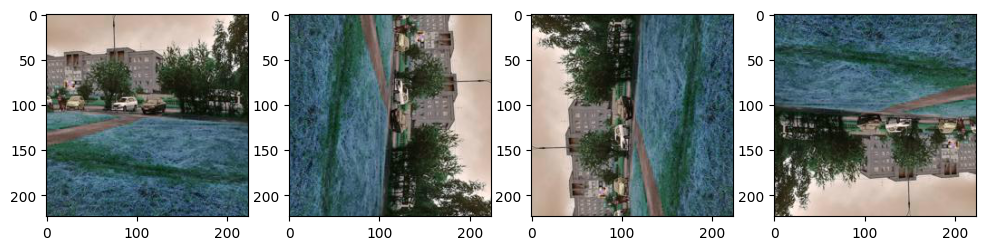

In [28]:
img222 = Image.open(sharp_path + str( sorted(os.listdir(sharp_path))[1] ))
fig, ax = plt.subplots(1,4, figsize=(12, 9))
ax[0].imshow(img222)
ax[1].imshow(img222.rotate(-90))
ax[2].imshow(img222.rotate(90)) 
ax[3].imshow(img222.rotate(180)) 

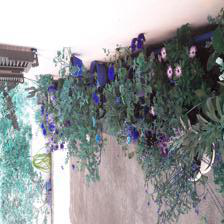

In [23]:
img222.rotate(90).show()

In [ ]:
def rotate(source_dir = os.path.join(path, 'blur')):
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        name, extension = os.path.splitext(file_name)
        img = Image.open(source_dir+'/'+file_name)
        r90r = img.rotate(-90)
        r90r.save(f'{source_dir}/' + f'{label}{i}'+f'{extension}')
        r90l = img.rotate(90)
        r90l.save(f'{source_dir}/' + f'{label}{i}'+f'{extension}')
        r180 = img.rotate(180)
        r180.save(f'{source_dir}/' + f'{label}{i}'+f'{extension}')

# Модель
Напишите здесь свою модель и визуализацию данных. 
Архитектура любая на ваше усмотрение (CNN, Transformers, SE blocks)
Используйте необходимые метрики, матрицу ошибок для анализа модели

Проверьте модель на тестовых данных 

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

In [ ]:
pic = Image.open(r'/content/motion_blurred/0_IPHONE-SE_M.JPG')

In [ ]:
pic.size

(1536, 2048)

# Пример датасета 
https://www.kaggle.com/kwentar/blur-dataset









































































































# Контакты

Вопросы можно задать в 
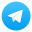


@JI_411

@dragynir


Удачи в выполнении задания!